In [3]:
import inspect
import os
import sys

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

#from evaporationLib import *

import numpy as np
import matplotlib.pyplot as plt  # Gives access to basic plotting functions
import matplotlib.gridspec as gridspec  # GRIDSPEC !
from natsort import natsorted
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

import matplotlib.ticker as ticker
from matplotlib import cm
cmap = cm.viridis_r
import pandas as pd
import matplotlib.tri as mtri
import csv

matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False
})

# Read the experimental flux CSV file into a DataFrame
df2 = pd.read_csv('../expFlux_mol_per_s.csv')
expFlux = df2['flux(mol/s)'].values


(1923, 2000)
The overall diffusive flux along pixel_y for 0 =3 is  0.0004824854526516888
The overall diffusive flux along pixel_y for 0 =6 is  0.0004693981859677722
The overall diffusive flux along pixel_y for 0 =9 is  0.0003164685576388406
The overall diffusive flux along pixel_y for 0 =12 is  0.000269168233862484
The overall diffusive flux along pixel_y for 0 =15 is  0.00022526439009486679
The overall diffusive flux along pixel_y for 0 =18 is  0.00018449478754494554
The overall diffusive flux along pixel_y for 0 =21 is  0.00014630079541747828
The overall diffusive flux along pixel_y for 0 =24 is  0.00011165285103216574
The overall diffusive flux along pixel_y for 0 =27 is  4.7843092575543805e-05
The overall diffusive flux along pixel_y for 0 =30 is  8.218490809002485e-06
The overall diffusive flux along pixel_y for 0 =33 is  -1.6216888923909892e-05
The overall diffusive flux along pixel_y for 0 =36 is  -3.080239749536095e-05
The overall diffusive flux along pixel_y for 0 =39 is  -2.8

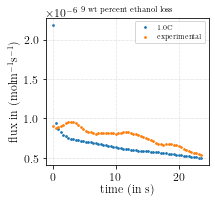

Done


In [4]:
# Start by creating the figure
width = 6.0
ratio = 0.35
ratio = 0.4
fig = plt.figure(1, figsize=(width, width * ratio))

# Now, create the gridspec structure, as required
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 0.25, 1])
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.05, hspace=0.03)

ax1 = plt.subplot(gs[0, 3])  # place it where it should be.

# Create a grid for the interpolation.
xi = np.linspace(0.0955, 0.1065, 2000)
mesh_dx = xi[1]-xi[0] # linspace is equidistant
yi = np.linspace(0.0, 0.0105765, 1923)
mesh_dy = yi[1]-yi[0] # linspace is equidistant
Xi, Yi = np.meshgrid(xi, yi)

diffusion_coefficient = 1.32E-05 # in m2/s

# Create a dictionary to store data for each target number
data_by_target = {}

# Calculate time for x-axis 
x_axis_time = np.linspace(0.0, 23.60, 60)
# 
folder_path = 'fieldData'

# Initialize data arrays for this target number
target_mean_fluxes = []
target_mean_fluxes_error = []
# Loop through the range of values from 400 to 24000 with a step of 400
time_range = list(range(0, 24000, 400))
for value in time_range:
    # Construct the complete filename
    filename = os.path.join(folder_path, f'time_{value}.csv')
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)#, delimiter=', ', engine='python')
    
    c_data = df['C'].values
    coords_0 = df['coords_0'].values
    coords_1 = df['coords_1'].values
    # create a triangulation of the (coords_0, coords_1) points
    triang = mtri.Triangulation(coords_0, coords_1)
    conc_interpolator = mtri.CubicTriInterpolator(triang, c_data, kind='geom')
    concentration_matrix = conc_interpolator(Xi, Yi)
    conc_grad_interpolation = conc_interpolator.gradient(Xi, Yi) # compute values for the gradient
    #######ax2.pcolormesh(concentration_matrix)
    masked_conc = concentration_matrix
    print (masked_conc.shape)
    ######### diffusion flux
    diffusion_flux_0_interpolation = - diffusion_coefficient * conc_grad_interpolation[0]
    diffusion_flux_1_interpolation = - diffusion_coefficient * conc_grad_interpolation[1]
    #########
    # grad_y, grad_x = np.gradient(masked_conc, mesh_dy, mesh_dx)#5.5E-6,5.5E-06)
    # diffusion_flux_1_interpolation = grad_y * (-1) * 1.32E-5
    # diffusion_flux_0_interpolation = grad_x * (-1) * 1.32E-5
    ##########
    horizontal_start = 818
    horizontal_end = 1364
    list_of_fluxes = []
    for pixels_above_edge in np.linspace(0.02E-3 / 5.5E-6, 1E-3 / 5.5E-6, 60, dtype=int):
        vertical_row =  pixels_above_edge #substrate_position +
        flux1 = np.trapz(diffusion_flux_1_interpolation[vertical_row, horizontal_start - pixels_above_edge:horizontal_end + pixels_above_edge],
                        dx=mesh_dy) #dx=5.5E-6
        
        flux2 = np.trapz(diffusion_flux_0_interpolation[0:vertical_row, horizontal_start - pixels_above_edge], dx=mesh_dx ) #dx=5.5E-6
    
        flux3 = np.trapz(diffusion_flux_0_interpolation[0:vertical_row, horizontal_end + pixels_above_edge], dx=mesh_dx) #dx=5.5E-6
        
        total_flux = flux1 + (flux3 - flux2)
        
        print('The overall diffusive flux along pixel_y for ' + str(value) + ' =' + str(pixels_above_edge) + ' is  ' + str(total_flux))
    
        list_of_fluxes.append(total_flux)
    mean_flux = np.mean(list_of_fluxes)
    target_mean_fluxes.append(mean_flux)
    print('The mean flux is ' + str(np.mean(list_of_fluxes)))
    error_of_mean = np.std(list_of_fluxes, ddof=1, keepdims=True) / (np.size(list_of_fluxes)) ** 0.5
    target_mean_fluxes_error.append(error_of_mean)
    print('The sample standard error of mean is ' + str(np.std(list_of_fluxes, ddof=1) / (np.size(list_of_fluxes)) ** 0.5))

target_mean_fluxes = [i*0.060 for i in target_mean_fluxes] 
# Specify the CSV file name
file_name = '9Loss_1.0C.csv'

# Combine the two lists into rows
rows = zip(x_axis_time, target_mean_fluxes)

# Write the rows into a CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['time(s)', 'flux(mol/s)'])  # Optional: Write column headers
    writer.writerows(rows)

# Store data for this target number in the dictionary
data_by_target[value] = {'mean_fluxes': target_mean_fluxes, 'mean_fluxes_error':target_mean_fluxes}

# Create a plot for each target number
for target_number, data in data_by_target.items():
    ax1.scatter(x_axis_time, data['mean_fluxes'], s=3, label='1.0C')
    #ax1.errorbar(x_axis_time, mean_fluxes[counter], yerr=error_of_mean[counter]) #fmt='o', capsize=5,

ax1.scatter(x_axis_time, expFlux,s=3, label='experimental')

#ax1.set_ylim(0.0,4E-5)
ax1.legend()
ax1.legend(prop={'size': 7})#(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4) #loc=2, prop={'size': 7}
ax1.set_xlabel(xlabel="time (in s)", labelpad=0.4)
ax1.set(ylabel='flux in ($\mathrm{mol} \mathrm{m^{-1}s^{-1}}$)')
#ax1.text(0.5, -0.32, 'b)', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
ax1.grid(b=None, which='major', axis='both', linestyle='dotted', lw=0.5)
ax1.set_title('9 wt percent ethanol loss', fontsize=8)
fig.savefig('simFluxes_9Loss.pdf', bbox_inches='tight', dpi=600.0)
#fig.savefig('N_All_Profiles.pgf', bbox_inches='tight', dpi=600)
plt.show()
print('Done')

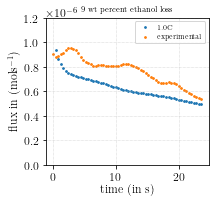

Done


In [8]:
# Read the CSV file into a DataFrame
# Start by creating the figure
width = 6.0
ratio = 0.35
ratio = 0.4
fig = plt.figure(1, figsize=(width, width * ratio))

# Now, create the gridspec structure, as required
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 0.25, 1])
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.05, hspace=0.03)

ax2 = plt.subplot(gs[0, 3])  # place it where it should be.
df = pd.read_csv('9Loss_1.0C.csv')#, delimiter=', ', engine='python')

flux = df['flux(mol/s)'].values
time = df['time(s)'].values

ax2.scatter(time,flux,s=3,label='1.0C')
ax2.scatter(time,expFlux,s=3,label='experimental')
ax2.legend()
ax2.set_ylim(0.0E-06,1.2E-06)
ax2.legend(prop={'size': 7})#(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4) #loc=2, prop={'size': 7}
ax2.set_xlabel(xlabel="time (in s)", labelpad=0.4)
ax2.set(ylabel='flux in ($\mathrm{mol} \mathrm{s^{-1}}$)')
#ax1.text(0.5, -0.32, 'b)', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
ax2.grid(b=None, which='major', axis='both', linestyle='dotted', lw=0.5)
ax2.set_title('9 wt percent ethanol loss', fontsize=8)
fig.savefig('simFluxes_9Loss_close.pdf', bbox_inches='tight', dpi=600.0)
#fig.savefig('N_All_Profiles.pgf', bbox_inches='tight', dpi=600)
plt.show()
print('Done')